# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.73KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

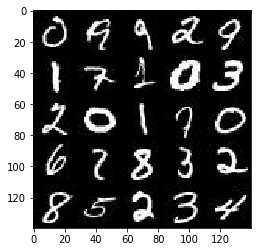

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

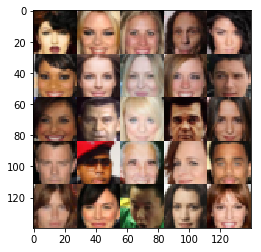

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name = 'real_input')
    fake_input = tf.placeholder(tf.float32,(None,z_dim),name='fake_input')
    lr = tf.placeholder(tf.float32,(),name='lr')

    return (real_input,fake_input,lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [24]:
def discriminator(images, reuse=False,alpha=0.02,stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer
                              (stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer
                              (stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer
                              (stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True,alpha=0.02,stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid',kernel_initializer=tf.random_normal_initializer
                                        (stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer
                                        (stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer
                                        (stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 32x32x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer
                                            (stddev=stddev))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
#     return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate,input_real:batch_images})
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 5.2628
Epoch 1/2... Discriminator Loss: 2.2256... Generator Loss: 8.3362
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 2.1497... Generator Loss: 0.1939
Epoch 1/2... Discriminator Loss: 0.6891... Generator Loss: 1.6328
Epoch 1/2... Discriminator Loss: 0.5593... Generator Loss: 2.4015
Epoch 1/2... Discriminator Loss: 1.5924... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 1.6098
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 2.8653
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.8250


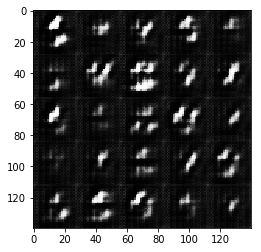

Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.3903
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.5308
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 2.4575
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 2.8446
Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 1.8671


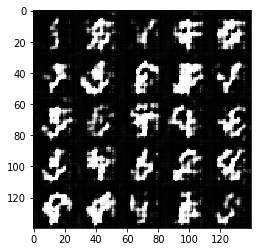

Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 1.7594
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 1.4074
Epoch 1/2... Discriminator Loss: 2.0013... Generator Loss: 0.2771
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.8283
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.0075


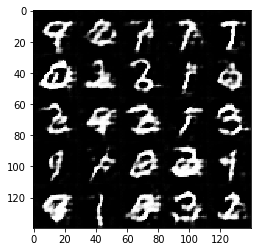

Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 2.1990
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.6347
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.6504
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 2.2896
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 1.0662
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 1.3987


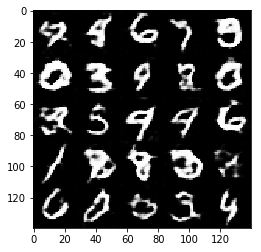

Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 1.3598
Epoch 1/2... Discriminator Loss: 1.6844... Generator Loss: 0.3631
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.2382


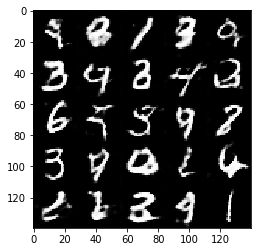

Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 2.1225
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.9925
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.8901


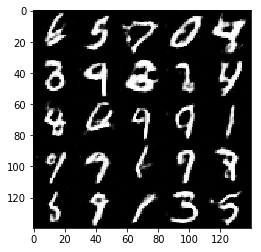

Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 1.2282... Generator Loss: 1.1656
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 1.1302


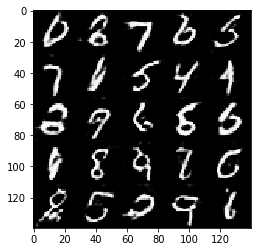

Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.5253
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.9743... Generator Loss: 0.2529
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.7769


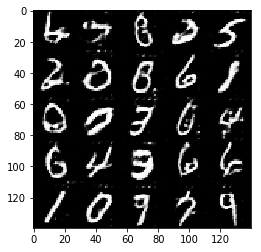

Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 1.5120
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 1.1248
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.5451
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.9224
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 1.5847


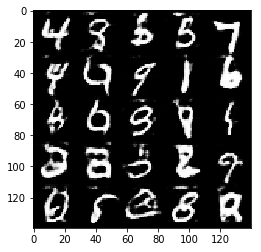

Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 1.6023
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 1.4707
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.9005
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 1.3068


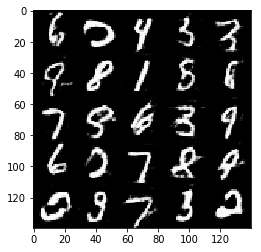

Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 1.2621
Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 0.4754
Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 1.0869
Epoch 2/2... Discriminator Loss: 1.4901... Generator Loss: 0.5154
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 1.6237


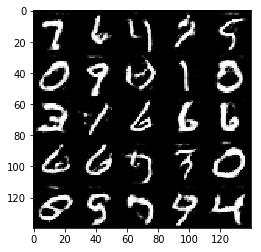

Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.7728
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 1.4189


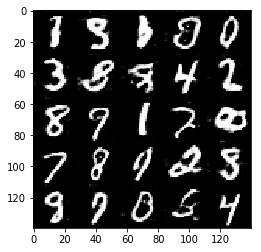

Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5274
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 1.5168... Generator Loss: 0.4577
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 1.1854
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.7804


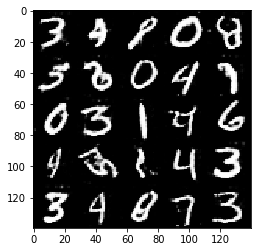

Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 1.0754
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 1.3922
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 1.3385
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.4644
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 0.9271


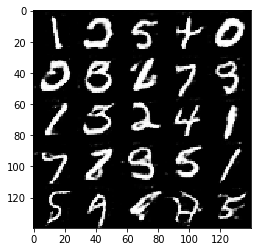

Epoch 2/2... Discriminator Loss: 1.8776... Generator Loss: 0.3224
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6985
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.5007
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 1.2190


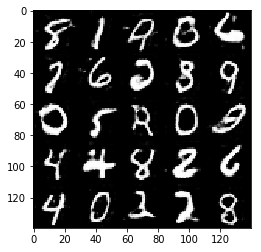

Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 1.4982
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 1.2463
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.9177


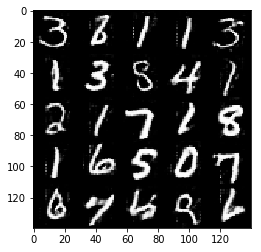

Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.4866
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 1.3340
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 1.3539
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 1.0781


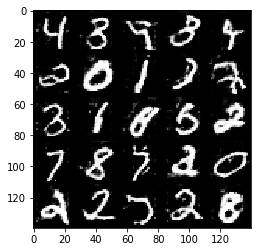

Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.6218
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 1.1152
Epoch 2/2... Discriminator Loss: 1.4421... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.4914


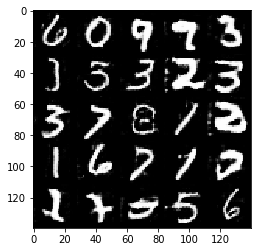

Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.4909
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 1.0734
Epoch 2/2... Discriminator Loss: 1.7454... Generator Loss: 0.3338


In [31]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 4.7311
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 3.8307
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 4.0032
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 6.6002
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 4.1394
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 2.0796
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 3.2011
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 11.9920
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 3.1064


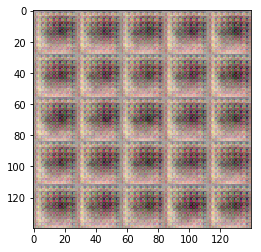

Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 4.5191
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 3.3071
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.2260
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.5632
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 2.6075
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.4496
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 3.1995
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 2.7387
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 2.7876
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.9888


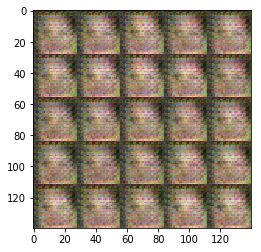

Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.5358
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 3.0014
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.2382
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.9241
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 4.5841
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 3.2276
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.6919
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.8697
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 5.5302


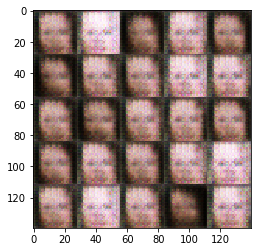

Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.6164
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.5840
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.9977
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.5666
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.4745
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.3614
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.7525
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 6.3545
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 2.2849


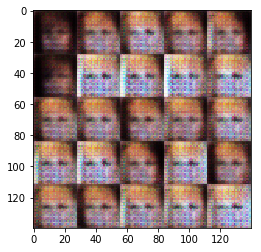

Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 2.2431
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.5208
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 4.7505
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.5118
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 2.8800
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.2151
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.8092
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 2.2528


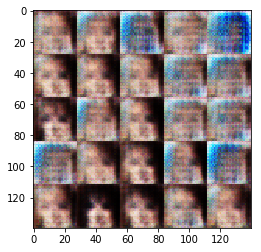

Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.9842
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.7591
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.2539
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.8077
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 3.0703
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.7128
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 3.4244
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.4664


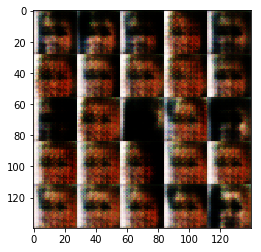

Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 3.2693
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 3.0481
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 2.6460
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 2.0232
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 2.8436
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 3.8629
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.4065
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 2.1737


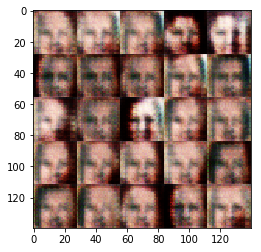

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 3.0248
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 2.5646
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.7459
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 2.5624
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.8237
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 3.3556


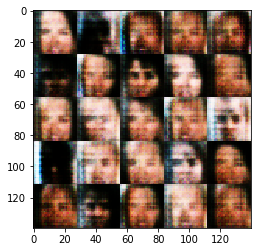

Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 2.1379
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.6325
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 2.1445
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 3.5748
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 2.3233
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.4618
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.1306


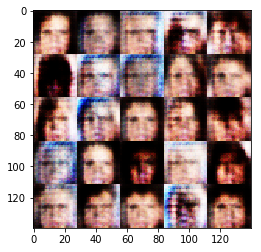

Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.9953
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 3.3382
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 2.4614
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 2.0484
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 2.4240
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 2.0162


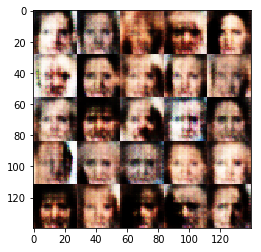

Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.5858
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 2.1854
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.7584


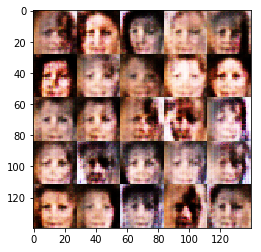

Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 2.1152
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 2.1932
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 2.4562
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.6999
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.1337


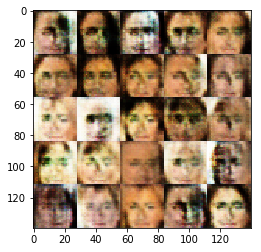

Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.8390
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 2.2597
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.8570


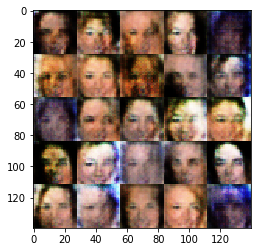

Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 3.1804
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 3.9397
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 2.0038
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9588


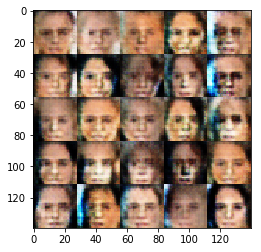

Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.6253
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.6994
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 2.1850
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 2.1653
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.7815


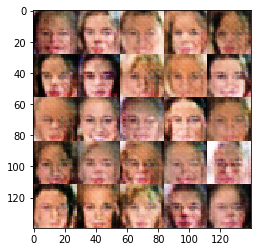

Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 2.5338
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 2.0721
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 1.7333
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.8630


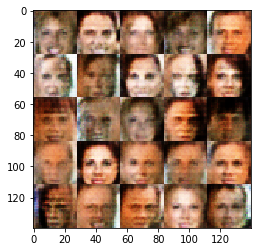

Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.6588
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.7765
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.3249


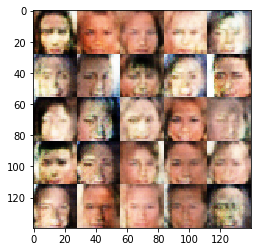

Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.7721... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.8481
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.5950


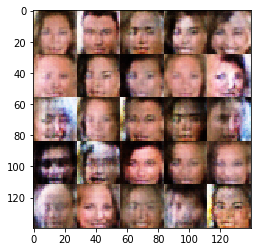

Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.9505
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 2.2974


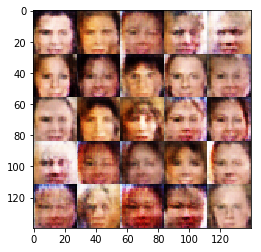

Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.8875
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8098


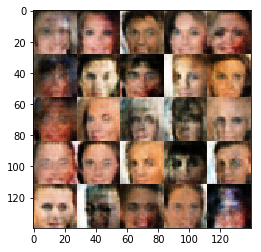

Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 2.0936
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 2.4186
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.9039
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.1058


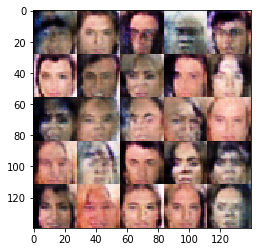

Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.6286
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 2.5633
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.5797
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 2.5327


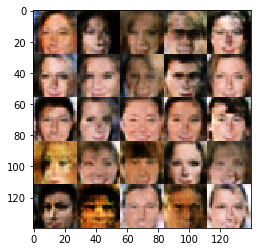

Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.5400
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.6897
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.5968


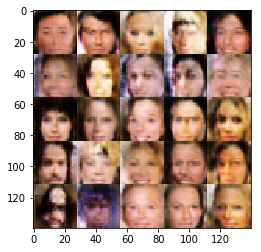

Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 2.0384
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 2.4289


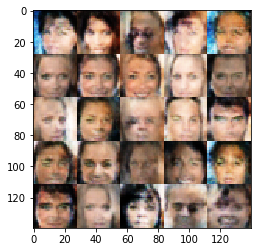

Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 1.0369


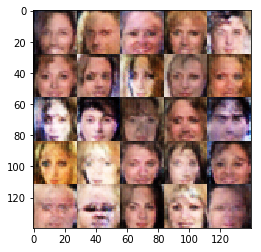

Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 2.6218
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9892


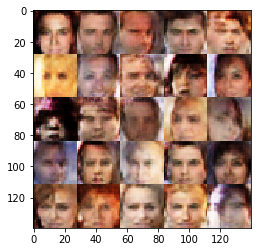

Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.5203
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.4370
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.9380


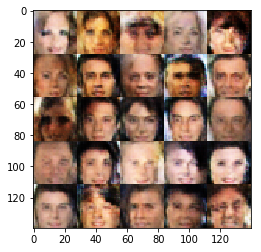

Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 2.2084
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.8971


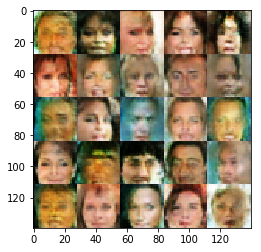

Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.9581
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 2.0079
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7727


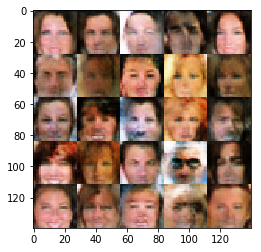

Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.2639
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 2.0650
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2225


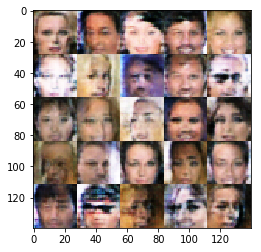

Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.5879
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.7354


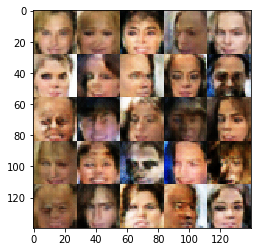

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.8253
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.5208
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.3070


In [32]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.